In [3]:

"""Generate ringdown templates in the time and perform parameter estimation on them.
"""

'Generate ringdown templates in the time and perform parameter estimation on them.\n'

In [4]:
#Import relevant modules, import data and all that
import time
import numpy as np
from scipy import interpolate
import corner
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from configparser import ConfigParser
import codecs
#plt.rcParams['font.family'] = 'DejaVu Sans'
#rc('text', usetex=True)
plt.rcParams.update({'font.size': 16.5})
from dynesty import utils as dyfunc


from multiprocessing import Pool
import h5py
import pandas as pd
import json
import qnm
import random
from multiprocessing import Pool
import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import resample_equal
import os
import csv
import argparse
import pickle
import scipy.optimize as optimization
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from pycbc.conversions import get_lm_f0tau_allmodes
from scipy.optimize import fsolve
import romspline
import rdown as rd

In [5]:
rdown=rd.Ringdown_Spectrum(1,0.9,2,2,n=0,s=-2)
w0, tau0 = rdown.QNM_spectrum()

In [6]:
rdown.rd_model_wtau([w0, tau0,1,2]);
rdown.rd_model_wq([w0, tau0,1,2]);

In [7]:
rdown=rd.Ringdown_Spectrum(1,0.9,2,2,n=0,s=-2,fixed=True)
rdown.rd_model_wq_fixed([1,2]);

In [8]:
# Cell that calls the arguments from your 'config.ini' file. 
try:
    parser = argparse.ArgumentParser(description="Simple argument parser")
    parser.add_argument("-c", action="store", dest="config_file")
    result = parser.parse_args()
    config_file=result.config_file
    parser = ConfigParser()
    parser.read(config_file)
    parser.sections()
except SystemExit: 
    parser = ConfigParser()
    parser.read('config_fixed_m_af.ini')
    parser.sections()
    pass

usage: ipykernel_launcher.py [-h] [-c CONFIG_FILE]
ipykernel_launcher.py: error: unrecognized arguments: -f /work/francisco.jimenez/.local/share/jupyter/runtime/kernel-62651e0b-c9d3-4156-9280-59d4da4ffa95.json


In [9]:
# path
rootpath=parser.get('nr-paths','rootpath')

simulation_path_1 = parser.get('nr-paths','simulation_path_1')
simulation_path_2 = parser.get('nr-paths','simulation_path_2')
metadata_file = parser.get('nr-paths','metadata_json')
simulation_number = parser.get('nr-paths','simulation_number')
simulation_number = np.int(simulation_number)

output_folder = parser.get('output-folder','output-folder')
overwrite = parser.get('setup','overwrite')
downfactor = np.int(parser.get('setup','plot_down_factor'))
sampler = parser.get('setup','sampler')
nr_code = parser.get('setup','nr_code')

if parser.has_option('setup','export'):
    export=eval(parser.get('setup','export'))
else:
    export=True

In [10]:
if parser.has_option('setup','nb_cores'):
    nbcores = np.int(parser.get('setup','nb_cores'))
else:
    nbcores = 1

In [11]:
if not os.path.exists(output_folder):
    os.mkdir(output_folder)
    print("Directory " , output_folder ,  " Created ")

In [12]:
# time config
tshift=parser.get('time-setup','tshift')
tshift = np.float(tshift)

tend=parser.get('time-setup','tend')
tend = np.float(tend)

t_align=parser.get('time-setup','t_align')
t_align = np.float(t_align)

In [13]:
# n-tones & nlive

nmax=parser.get('n-tones','nmax')
nmax = np.int(nmax)

npoints=parser.get('n-live-points','npoints')
npoints = np.int(npoints)

In [14]:
filename = "/work/sumit.kumar/projects/ringdown/xisco/feb2021_injections/intrinsic/injection_2tones.hdf"
files = h5py.File(filename, 'r')
files.attrs.keys()
#gw[simulation_number]["Extrapolated_N3.dir"]["Y_l2_m2.dat"] 
#magic.from_file(filename)
#help(files.attrs)
files.attrs.values

<bound method MappingHDF5.values of <Attributes of HDF5 object at 139825649827280>>

In [15]:
# model
model=parser.get('rd-model','model')
error_str = eval(parser.get('rd-model','error_str'))
fitnoise=eval(parser.get('rd-model','fit_noise'))
#fitnoise=False
if error_str:
    error_val=np.float(parser.get('rd-model','error_val'))
    if error_val==0:
        error_type=''
    else:
        error_type=error_val
else:
    error_type='False'
    error_val =0

if model == 'w-q':
    tau_var_str='q'
else:
    tau_var_str='tau'
    
#tshift=10
#npoints=10000
#export=False
print('model:',model)
print('nmax:',nmax)
print('tshift:',tshift)
print('error:', error_str)
print('error value:',error_type)
print('export:',export)
print('nr code:',nr_code)

model: w-tau-fixed-m-af
nmax: 0
tshift: 0.0
error: False
error value: False
export: True
nr code: SXS


In [16]:
if error_str:
    output_folder_1=output_folder+'/'+model+'-nmax'+str(nmax)+'_'+str(error_str)+'_'+str(error_type)+'_fitnoise_'+str(fitnoise)
else:
    output_folder_1=output_folder+'/'+model+'-nmax'+str(nmax)+'_'+str(error_str)+'_fitnoise_'+str(fitnoise)

if not os.path.exists(output_folder_1):
    os.mkdir(output_folder_1)
    print("Directory " , output_folder_1 ,  " Created ")

In [17]:
corner_plot=output_folder_1+'/Dynesty_'+str(simulation_number)+'_'+model+'_nmax='+str(nmax)+'_tshift='+str(tshift)+'_'+str(npoints)+'corner_plot.png'
corner_plot_extra=output_folder_1+'/Dynesty_'+str(simulation_number)+'_'+model+'_nmax='+str(nmax)+'_tshift='+str(tshift)+'_'+str(npoints)+'corner_plot_extra.png'
diagnosis_plot=output_folder_1+'/Dynesty_diagnosis'+str(simulation_number)+'_'+model+'_nmax='+str(nmax)+'_tshift='+str(tshift)+'_'+str(npoints)+'.png'
fit_plot=output_folder_1+'/Fit_results_'+str(simulation_number)+'tshift_'+str(tshift)+'_'+model+'_nmax_'+str(nmax)+'.png'
samples_file=output_folder_1+'/posterior_samples-'+str(simulation_number)+'tshift_'+str(tshift)+'_'+model+'_nmax_'+str(nmax)+'.csv'
results_file=output_folder_1+'/results_'+str(simulation_number)+'tshift_'+str(tshift)+'_'+model+'_nmax_'+str(nmax)+'.pkl'

In [18]:
sumary_data = output_folder_1+'/summary'+str(simulation_number)+'_'+model+'_nmax_'+str(nmax)+'.csv'
best_data=output_folder_1+'/best_values_'+str(simulation_number)+'_'+model+'_nmax_'+str(nmax)+'.csv'

In [19]:
vary_fund = True

#sampler parameters
dim = nmax+1
ndim = 4*dim
numbins = 32 #corner plot parameter - how many bins you want
datacolor = '#105670' #'#4fa3a7'
pkcolor = '#f2c977' #'#ffb45f'
mediancolor = '#f7695c' #'#9b2814'

#Import data and necessary functions
#TimeOfMaximum
def FindTmaximum(y):
    """ It determines the maximum absolute value of the complex waveform.
    """
    absval = np.sqrt(y[:,1]*y[:,1]+y[:,2]*y[:,2])
    vmax=np.max(absval)
    index = np.argmax(absval == vmax)
    timemax=y[index,0]
    return timemax

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


def EasyMatchT(t,h1,h2,tmin,tmax):
    """ It computes the time-domain match for (h1|h2)  complex waveforms.
    """
    pos = np.argmax(t >= (tmin));
    
    h1red=h1[pos:];
    h2red=h2[pos:];
    
    norm1=np.sum(np.abs(h1red)**2)
    norm2=np.sum(np.abs(h2red)**2)

    myTable=h1red*np.conjugate(h2red)
    res=((np.sum(myTable)/np.sqrt(norm1*norm2))).real
    
    return res

def EasySNRT(t,h1,h2,tmin,tmax):
    """ It computes the time-domain snr for (h1|h2)  complex waveforms.
    """    
    pos = np.argmax(t >= (tmin));
    
    h1red=h1[pos:];
    h2red=h2[pos:];

    myTable=h1red*np.conjugate(h2red)
    res=2*np.sqrt((np.sum(myTable)).real)
    
    return res

def wRD_to_f_Phys(f,M):
    """ It converts NR frequencies to physical units in [Hz].
    """  
    c=2.99792458*10**8;G=6.67259*10**(-11);MS=1.9885*10**30;
    return (c**3/(M*MS*G*2*np.pi))*f

def wRD_to_f_NR(f,M):
    """ It converts Physical frequencies to NR units in [1/M].
    """  
    c=2.99792458*10**8;G=6.67259*10**(-11);MS=1.9885*10**30;
    return (c**3/(M*MS*G*2*np.pi))*f

def tauRD_to_t_Phys(tau,M):
    """ It converts NR times to physical units in [s].
    """  
    c=2.99792458*10**8;G=6.67259*10**(-11);MS=1.9885*10**30;
    return ((M*MS*G)/c**3)*tau

def tauRD_to_t_NR(tau,M):
    """ It converts Physical times to NR units in [M].
    """  
    c=2.99792458*10**8;G=6.67259*10**(-11);MS=1.9885*10**30;
    return 1/((M*MS*G)/c**3)*tau

def twopoint_autocovariance(t,n):
    """ It computes the two-point autocovariance function.
    """  
    dt=t[1]-t[0]
    res = np.zeros(len(n))
    taus = np.zeros(len(n))
    for tau in range(0,int(len(n)/2)):
        ntau=np.roll(n, tau)
        taus[tau] = t[tau]
        res[tau]=np.sum(n*ntau).real
    return (taus[:int(len(n)/2)],res[:int(len(n)/2)])

grav_220 = [qnm.modes_cache(s=-2,l=2,m=2,n=i) for i in range (0,dim)]
def QNM_spectrum_old(mf,af,l,m):
    """ It computes the RD frequencies and damping times in NR units.
    """     
    omegas_new_v2 = [qnm.modes_cache(s=-2,l=l,m=m,n=i)(a=af)[0] for i in range (0,dim)]
    w_m_a = (np.real(omegas_new_v2))/mf
    tau_m_a=-1/(np.imag(omegas_new_v2))*mf
    
    return (w_m_a, tau_m_a)

def QNM_spectrum(mf,af,l,m):
    """ It computes the RD frequencies and damping times in NR units.
    """     
    omegas_new=np.asarray([grav_220[i](a=af)[0] for i in range (0,dim)])
    w_m_a = (np.real(omegas_new))/mf
    tau_m_a=-1/(np.imag(omegas_new))*mf
    
    return (w_m_a, tau_m_a)

def QNM_Berti(mf,af,l,m):
    """ It computes the RD frequencies and damping times in NR units.
    """     
    position=np.argmax(rdowndata[0,0] >= (af))
    #w_m_a=f1+f2*(1-af)**f3
    w_m_a=[None]*(nmax+1)
    tau_ma_a=[None]*(nmax+1)
    
    for i in range(nmax+1):
        qnm=rdowndata[i,1:3,position]
        w_m_a[i] = qnm[0]/mf
        tau_ma_a[i] = -1/(qnm[1])*mf

    return w_m_a, tau_ma_a

f_fpars= [[2.95845, -2.58697, 0.0533469], [2.12539, -1.78054, 
  0.0865503], [1.74755, -1.44776, 0.123666], [1.78287, -1.53203, 
  0.129475], [2.04028, -1.83224, 0.112497]]

q_fpars=[[0.584077, 1.52053, -0.480658], [0.00561441, 
  0.630715, -0.432664], [-0.197965, 0.515956, -0.369706], [-0.275097, 
  0.455691, -0.331543], [-0.287596, 0.398514, -0.309799]]

def w_fpars_Berti(n):
    return f_fpars[n]

def tau_qpars_Berti(n):
    return q_fpars[n]

def mass_from_wtau(n,w,tau):
    f1,f2,f3 = w_fpars_Berti(n)
    q1,q2,q3 = tau_qpars_Berti(n)
    res=(f1 + f2*(2**(-1/q3)*((-2*q1 + w*tau)/q2)**(1/q3))**f3)/w
    return res

def spin_from_wtau(n,w,tau):
    f1,f2,f3 = w_fpars_Berti(n)
    q1,q2,q3 = tau_qpars_Berti(n)
    res=1 - 2**(-1/q3)*((-2*q1 + w*tau)/q2)**(1/q3)
    return res

def mass_from_wtau_loop(w,tau,l,m):
    res=[None]*dim
    for n in range (0,dim):
        f1,f2,f3 = w_fpars_Berti(n)
        q1,q2,q3 = tau_qpars_Berti(n)
        res[n]=(f1 + f2*(2**(-1/q3)*((-2*q1 + w[n]*tau[n])/q2)**(1/q3))**f3)/w[n]
    return res

def spin_from_wtau_loop(w,tau,l,m):
    res=[None]*dim
    for n in range (0,dim):
        f1,f2,f3 = w_fpars_Berti(n)
        q1,q2,q3 = tau_qpars_Berti(n)
        res[n]= 1 - 2**(-1/q3)*((-2*q1 + w[n]*tau[n])/q2)**(1/q3)
    return res

In [20]:
def FFT_FreqBins(times):
    Len = len(times)
    DeltaT = times[-1]- times[0]
    dt = DeltaT/(Len-1)
    dnu = 1/(Len*dt)
    maxfreq = 1/(2*dt)
    add = dnu/4

    p = np.arange(0.0,maxfreq+add,dnu)
    m = np.arange(p[-1]-(2*maxfreq)+dnu,-dnu/2+add,dnu)
    res=np.concatenate((p,m))
    
    return res

def hFromPsi4FFI(tpsi4,f0):
    
    timecheck1=tpsi4[-2,0]-tpsi4[-1,0]
    timecheck2=tpsi4[1,0]-tpsi4[0,0]
    
    if np.abs(timecheck1-timecheck2)>=0.0001:
        print("The data might not be equally sampled!!")

    times,data= tpsi4[:,0],tpsi4[:,1]

    freqs = FT_FreqBins(xaxis.real).real
    position = np.argmax(freqs >= f0)
    freqs[:position]=f0*np.ones(len(freqs[:position]))
    freqs=2*np.pi*freqs

    fdata=fft(data)
    len(myTable)*ifft(- fdata/floor**2);
    np.stack((times,data)).T


In [21]:
2*np.sqrt(12/2*1/tauRD_to_t_NR(1.3*10**-47,70)*(5*10**(-21))**2)

126.13393146339718

In [22]:
1/tauRD_to_t_NR(1.3*10**-47,70)*(5*10**(-21))**2

662.9070277672074

In [23]:
2*np.sqrt(0.004/2*1/(1.3*10**-47)*(5*10**(-21))**2)

124.03473458920845

In [24]:
np.sqrt(1/(1.3*10**-47)*(5*10**(-21))**2)

1386.7504905630728

In [25]:
gw = {}
gw[simulation_number] = h5py.File(simulation_path_1, 'r') 
if nr_code=='SXS': 
    gw_sxs_bbh_0305 = gw[simulation_number]["Extrapolated_N3.dir"]["Y_l2_m2.dat"] 
    times = gw_sxs_bbh_0305[:,0]
    gw5 = {}
    gw5[simulation_number] = h5py.File(simulation_path_2, 'r')
    gw5_sxs_bbh_0305 = gw5[simulation_number]["Extrapolated_N3.dir"]["Y_l2_m2.dat"]

elif nr_code=='Maya': 
    dt=0.1
    gw_sxs_bbh_0305_amp = np.asarray(gw[simulation_number]['amp_l2_m2/Y'])[6:] 
    times_1 = np.asarray(gw[simulation_number]['amp_l2_m2/X'])[6:] 
    gw_sxs_bbh_0305_amp_int = romspline.ReducedOrderSpline(times_1, gw_sxs_bbh_0305_amp)
    gw_sxs_bbh_0305_pha = np.asarray(gw[simulation_number]['phase_l2_m2/Y'])[6:]
    times = np.asarray(gw[simulation_number]['phase_l2_m2/X'])[6:]
    gw_sxs_bbh_0305_pha_int = romspline.ReducedOrderSpline(times, gw_sxs_bbh_0305_pha)
    
    tmin=max(times_1[0],times[0])
    tmax=min(times_1[-1],times[-1])
    times=np.arange(tmin,tmax,dt)
    amps=gw_sxs_bbh_0305_amp_int(times)
    phs=gw_sxs_bbh_0305_pha_int(times)
    gw_sxs_bbh_0305 = np.asarray([times,amps*np.cos(phs),amps*np.sin(phs)]).T
    gw5_sxs_bbh_0305 = gw_sxs_bbh_0305
    
elif nr_code=='LaZeV': 
    #gw_sxs_bbh_0305_amp = np.asarray(gw[simulation_number]['amp_l2_m2/Y'])[6:] 
    #gw_sxs_bbh_0305_amp_err = np.asarray(gw[simulation_number]['amp_l2_m2/errors']) 
    #times_1 = np.asarray(gw[simulation_number]['amp_l2_m2/X'])[6:] 
    #gw_sxs_bbh_0305_amp_int = interp1d(times_1, gw_sxs_bbh_0305_amp, kind='cubic') 
    #gw_sxs_bbh_0305_amp_errs_int = interp1d(times_1, gw_sxs_bbh_0305_amp_err, kind='cubic')
    
    #gw_sxs_bbh_0305_pha = np.asarray(gw[simulation_number]['phase_l2_m2/Y'])[6:]
    #gw_sxs_bbh_0305_pha_err = np.asarray(gw[simulation_number]['phase_l2_m2/errors'])
    #times = np.asarray(gw[simulation_number]['phase_l2_m2/X'])[6:]
    #gw_sxs_bbh_0305_pha_int = interp1d(times, gw_sxs_bbh_0305_pha, kind='cubic')
    #gw_sxs_bbh_0305_pha_errs_int = interp1d(times, gw_sxs_bbh_0305_pha_err, kind='cubic')
    #position = np.argmax(times >= times_1[0])
    #times = times[position:]
    
    
    #amps=gw_sxs_bbh_0305_amp_int(times) 
    #amps_err=gw_sxs_bbh_0305_amp_errs_int(times) 

    #phs=gw_sxs_bbh_0305_pha_int(times)
    #phs_err=-gw_sxs_bbh_0305_pha_errs_int(times)

    #gw_sxs_bbh_0305 = np.asarray([times,amps*np.cos(phs),amps*np.sin(phs)]).T
    # the sqrt(2) is to correct the double weight of the errror
    #error_lav = np.sqrt(amps_err**2+ (amps**2)*phs_err**2)/np.sqrt(2)
    #gw5_sxs_bbh_0305 = np.asarray([times,gw_sxs_bbh_0305[:,1]+error_lav,gw_sxs_bbh_0305[:,2]+error_lav]).T
    
    dt=0.1
    gw_sxs_bbh_0305_amp = np.asarray(gw[simulation_number]['amp_l2_m2/Y'])[6:] 
    times_1 = np.asarray(gw[simulation_number]['amp_l2_m2/X'])[6:] 
    gw_sxs_bbh_0305_amp_int = romspline.ReducedOrderSpline(times_1, gw_sxs_bbh_0305_amp)
    gw_sxs_bbh_0305_pha = np.asarray(gw[simulation_number]['phase_l2_m2/Y'])[6:]
    times = np.asarray(gw[simulation_number]['phase_l2_m2/X'])[6:]
    gw_sxs_bbh_0305_pha_int = romspline.ReducedOrderSpline(times, gw_sxs_bbh_0305_pha)
    
    tmin=max(times_1[0],times[0])
    tmax=min(times_1[-1],times[-1])
    times=np.arange(tmin,tmax,dt)
    amps=gw_sxs_bbh_0305_amp_int(times)
    phs=gw_sxs_bbh_0305_pha_int(times)
    gw_sxs_bbh_0305 = np.asarray([times,amps*np.cos(phs),amps*np.sin(phs)]).T
    gw5_sxs_bbh_0305 = gw_sxs_bbh_0305

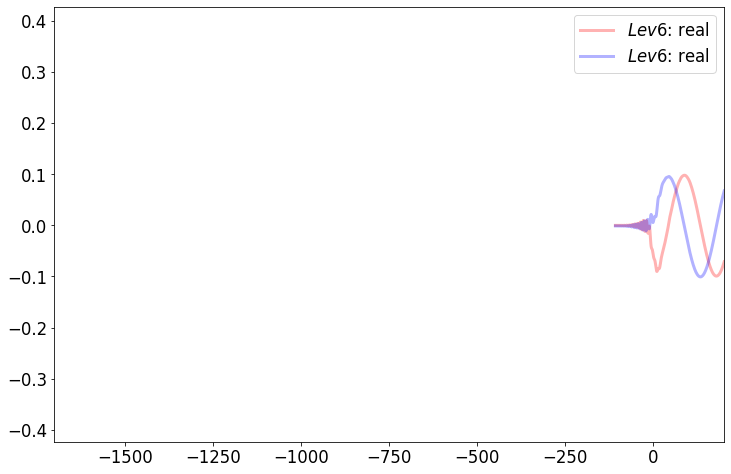

In [26]:
#Test plot real part (data was picked in the last cell). Aligning in time
plt.figure(figsize = (12, 8))
plt.plot(times,gw_sxs_bbh_0305[:,1], "r", alpha=0.3, lw=3, label=r'$Lev6$: real')
plt.plot(times, gw_sxs_bbh_0305[:,2], "b", alpha=0.3, lw=3, label=r'$Lev6$: real')
plt.xlim(-1700,200)
plt.legend()

In [28]:
if nr_code=='SXS':
    metadata = {}
    with open(metadata_file) as file:
        metadata[simulation_number] = json.load(file)

    af = metadata[simulation_number]['remnant_dimensionless_spin'][-1]
    mf = metadata[simulation_number]['remnant_mass']

elif nr_code=='Maya':
    af = 0.6861
    mf = 0.9515

elif nr_code=='LaZeV':    
    metadata = {}
    #with open(metadata_file) as file:
    #    metadata[simulation_number] = json.load(file)
    fread = open(metadata_file, "r")
    metadata = fread.readlines()
   
    af = 0.6919694604
    mf = 0.9520211506
    
#times --> x axis of your data
times = gw_sxs_bbh_0305[:,0]
tmax=FindTmaximum(gw_sxs_bbh_0305[round(len(gw_sxs_bbh_0305)/2):])
times = times - tmax

#times 6--> x axis of your data
times5 = gw5_sxs_bbh_0305[:,0]
tmax5=FindTmaximum(gw5_sxs_bbh_0305[round(len(gw_sxs_bbh_0305)/2):])
times5 = times5 - tmax5

In [29]:
if parser.has_option('setup','qnm_model'):
    qnm_model='berti'
    rdownfolders=np.asarray([rootpath+'/RDmodes/l2/n'+str(i+1)+'l2m2.dat' for i in range(nmax+1)])
    rdowndata = np.asarray([np.loadtxt(rdownfolders[i]).T for i in range(len(rdownfolders))])
    w , tau  = QNM_Berti(mf,af,2,2)
else:
    qnm_model='qnm'
    w , tau = QNM_spectrum(mf,af,2,2)
    
    

In [30]:
# loading priors
w_mins=np.empty(nmax+1)
w_maxs=np.empty(nmax+1)
tau_mins=np.empty(nmax+1)
tau_maxs=np.empty(nmax+1)
a_mins=np.empty(nmax+1)
a_maxs=np.empty(nmax+1)
ph_mins=np.empty(nmax+1)
ph_maxs=np.empty(nmax+1)

for i in range(nmax+1): 
    wp_min=parser.get('prior-w'+str(i),'w'+str(i)+'_min')
    w_mins[i] = np.float(wp_min)
    
    wp_max=parser.get('prior-w'+str(i),'w'+str(i)+'_max')
    w_maxs[i] = np.float(wp_max)
    
    taup_min=parser.get('prior-'+tau_var_str+str(i),tau_var_str+str(i)+'_min')
    tau_mins[i] = np.float(taup_min)
    
    taup_max=parser.get('prior-'+tau_var_str+str(i),tau_var_str+str(i)+'_max')
    tau_maxs[i] = np.float(taup_max)
    
    amp0_min=parser.get('prior-amp'+str(i),'amp'+str(i)+'_min')
    a_mins[i] = np.float(amp0_min)
    
    amp1_max=parser.get('prior-amp'+str(i),'amp'+str(i)+'_max')
    a_maxs[i] = np.float(amp1_max)
    
    phase_min=parser.get('prior-phase'+str(i),'phase'+str(i)+'_min')
    ph_mins[i] = np.float(phase_min)*2*np.pi
    
    phase_max=parser.get('prior-phase'+str(i),'phase'+str(i)+'_max')
    ph_maxs[i] = np.float(phase_max)*2*np.pi
    
priors_min = np.concatenate((w_mins,tau_mins,a_mins,ph_mins))
priors_max = np.concatenate((w_maxs,tau_maxs,a_maxs,ph_maxs))
prior_dim = len(priors_min)
priors=np.column_stack((priors_min,priors_max))

if model == 'w-tau-fixed':
    priors_min = np.concatenate((a_mins,ph_mins))
    priors_max = np.concatenate((a_maxs,ph_maxs))
    prior_dim = len(priors_min)
    priors=np.column_stack((priors_min,priors_max))

elif model ==  'w-tau-fixed-m-af':
    mass_min=[np.float(parser.get('prior-mass','mass_min'))]
    mass_max=[np.float(parser.get('prior-mass','mass_max'))]
    spin_min=[np.float(parser.get('prior-spin','spin_min'))]
    spin_max=[np.float(parser.get('prior-spin','spin_max'))]
    priors_min = np.concatenate((a_mins,ph_mins,mass_min,spin_min))
    priors_max = np.concatenate((a_maxs,ph_maxs,mass_max,spin_max))
    prior_dim = len(priors_min)
    priors=np.column_stack((priors_min,priors_max))


if fitnoise:
    l_int=1
    index_mass=-3
    index_spin=-2
    priors_fit_min=[np.float(parser.get('prior-noise','noise_min'))]
    priors_fit_max=[np.float(parser.get('prior-noise','noise_max'))]
    priors_min = np.concatenate((priors_min,priors_fit_min))
    priors_max = np.concatenate((priors_max,priors_fit_max))
    priors=np.column_stack((priors_min,priors_max))
    prior_dim = len(priors_min)
else: 
    index_mass=-2
    index_spin=-1
    l_int=0
    
#a_maxs[1]=20
a_maxs

array([3.])

In [31]:
#Select the data from 0 onwards
position = np.argmax( times >= (t_align))
position5 = np.argmax(times5 >= (t_align))
gw_sxs_bbh_0305rd=gw_sxs_bbh_0305[position+1:]
gw_sxs_bbh_0305rd5=gw5_sxs_bbh_0305[position5+1:]
timesrd=gw_sxs_bbh_0305[position:-1][:,0][:]-tmax
timesrd5=gw5_sxs_bbh_0305[position5:-1][:,0][:]-tmax5

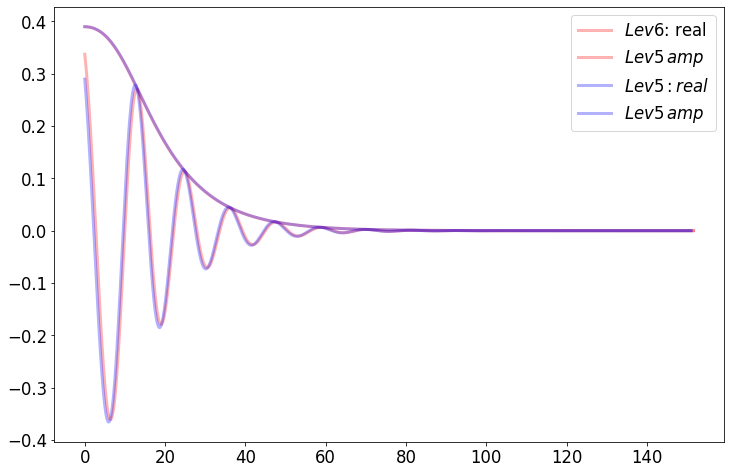

In [32]:
#Test plot real part (data was picked in the last cell). Aligning in time
plt.figure(figsize = (12, 8))
plt.plot(timesrd, gw_sxs_bbh_0305rd[:,1], "r", alpha=0.3, lw=3, label=r'$Lev6$: real')
plt.plot(timesrd, np.sqrt(gw_sxs_bbh_0305rd[:,1]**2+gw_sxs_bbh_0305rd[:,2]**2), "r", alpha=0.3, lw=3, label=r'$Lev5\,amp$')
plt.plot(timesrd5, gw_sxs_bbh_0305rd5[:,1], "b", alpha=0.3, lw=3, label=r'$Lev5: real$')
plt.plot(timesrd5, np.sqrt(gw_sxs_bbh_0305rd5[:,1]**2+gw_sxs_bbh_0305rd5[:,2]**2), "b", alpha=0.3, lw=3, label=r'$Lev5\,amp$')
plt.legend()

In [33]:
#[plt.errorbar(csv_data_fixed[i]['t_shift'], -csv_data_fixed[i]['dlogz'], yerr=csv_data_fixed[i]['dlogz_err'], fmt='o',color=colors[i],label =tags_fixed[i]) for i in range(len(csv_data_fixed))] 

In [34]:
gwnew_re = interpolate.interp1d(timesrd, gw_sxs_bbh_0305rd[:,1], kind = 'cubic')
gwnew_im = interpolate.interp1d(timesrd, gw_sxs_bbh_0305rd[:,2], kind = 'cubic')

gwnew_re5 = interpolate.interp1d(timesrd5, gw_sxs_bbh_0305rd5[:,1], kind = 'cubic')
gwnew_im5 = interpolate.interp1d(timesrd5, gw_sxs_bbh_0305rd5[:,2], kind = 'cubic')

In [35]:
if timesrd5[-1]>= timesrd[-1]: 
    timesrd_final = timesrd
else:
    timesrd_final = timesrd5

gwdatanew_re = gwnew_re(timesrd_final)
gwdatanew_im = gwnew_im(timesrd_final)
gwdatanew_re5 = gwnew_re5(timesrd_final)
gwdatanew_im5 = gwnew_im5(timesrd_final)

gwdatanew = gwdatanew_re - 1j*gwdatanew_im
gwdatanew5 = gwdatanew_re5- 1j*gwdatanew_im5

In [36]:
#taus, corr= twopoint_autocovariance(timesrd,gwdatanew-gwdatanew5)
#plt.figure(figsize = (12, 8))
#plt.plot(taus, corr,'ro')
#plt.show()
#vmax=np.max(corr)
#index = np.argmax(corr == vmax)
#taus[index]
print(w)
print(tau)

[0.5557886630104557]
[11.740978066949138]


In [37]:
mismatch=1-EasyMatchT(timesrd_final,gwdatanew,gwdatanew5,0,0+90)
error=np.sqrt(2*mismatch)
print('error estimate:',error)
print('mismatch:', mismatch)
print('snr:', EasySNRT(timesrd_final,gwdatanew,gwdatanew,0,0+90)/error**2)

error estimate: 0.20053883528563624
mismatch: 0.02010791222885977
snr: 229.43188441714122


In [38]:
if error_str and error_val==0:
    error = np.sqrt(gwdatanew*gwdatanew-2*gwdatanew*gwdatanew5+gwdatanew5*gwdatanew5)
    error_est=np.sqrt(error.imag**2+error.real**2)
    plt.figure(figsize = (12, 8))
    plt.plot(timesrd_final, gwdatanew.real, "r", alpha=0.3, lw=2, label='Lev6')
    plt.plot(timesrd_final, gwdatanew5.real, "b", alpha=0.3, lw=2, label='Lev5')
    plt.plot(timesrd_final, error_est, "b", alpha=0.3, lw=2, label='error')
    plt.legend()

In [39]:
if parser.has_option('rd-model','phase_alignment'):
    phase_alignment=eval(parser.get('rd-model','phase_alignment'))    
else:
    phase_alignment=False

In [40]:
# Phase alignement
if phase_alignment:
    phas = np.angle(gwdatanew)
    phas = np.unwrap(phas)
    phas5 = np.angle(gwdatanew5)
    phas5 = np.unwrap(phas5)
    position = np.argmax(timesrd_final >= (t_align))
    dphase = phas5[position]-phas[position]
    gwdatanew = (gwdatanew_re - 1j*gwdatanew_im)*np.exp(1j*dphase)
    gw_sxs_bbh_0305rd6=gw5_sxs_bbh_0305[position5:-1]
    timesrd=gw_sxs_bbh_0305[position:-1][:,0][:920]
    mismatch=1-EasyMatchT(timesrd_final,gwdatanew,gwdatanew5,0,+90)
    error=np.sqrt(2*mismatch)
    print('error estimate:',error)
    print('mismatch:', mismatch)
    print('snr:', EasySNRT(timesrd_final,gwdatanew,gwdatanew5,0,0+90)/error)
    if error_str:
        error = np.sqrt(gwdatanew*gwdatanew-2*gwdatanew*gwdatanew5+gwdatanew5*gwdatanew5)
        error_est=np.sqrt(error.imag**2+error.real**2)
    else :
        error = 1 
        EasySNRT(timesrd_final,gwdatanew,gwdatanew5/error,0,0+90)

error estimate: 0.007733513376553806
mismatch: 2.9903614572668324e-05
snr: 1194.6164108903329


In [41]:
#Test the new interpolated data
if error_str and error_val==0:
    plt.figure(figsize = (12, 8))
    plt.plot(timesrd_final, gwdatanew.real, "r", alpha=0.3, lw=2, label='Lev6')
    plt.plot(timesrd_final, gwdatanew5.real, "b", alpha=0.3, lw=2, label='Lev5')
    plt.plot(timesrd_final, error.real, "b", alpha=0.3, lw=2, label='error')
    plt.legend()

In [42]:
#Test the error data
if error_str and error_val==0:
    plt.figure(figsize = (12, 8))
    plt.plot(timesrd_final, error_est, "r", alpha=0.3, lw=2, label='all error')
    plt.legend()

In [43]:
#Test the error data
if error_str and error_val==0:
    plt.figure(figsize = (12, 8))
    plt.xlim(1,40)
    plt.ylim(-300,300)
    plt.plot(timesrd_final,gwdatanew.real/np.sqrt(error.imag**2+error.real**2), "r", alpha=0.3, lw=2, label='all error')
    plt.legend()

In [44]:
#Take the piece of waveform you want
position_in = np.argmax(timesrd_final >= tshift)
position_end = np.argmax(timesrd_final >= tend)
timesrd_final_tsh = timesrd_final[position_in:position_end]
#gwdatanew_re_tsh = gwdatanew_re[position_in:position_end]
#gwdatanew_im_tsh = gwdatanew_im[position_in:position_end]
gwdatanew_re_tsh = gwdatanew_re[position_in:position_end]
gwdatanew_im_tsh = gwdatanew_im[position_in:position_end]
if error_str and error_val==0:
    error_tsh=error[position_in:position_end]
    error_final=(error_tsh.real**2+error_tsh.imag**2)
    norm_factor = 100*len(error_final)/2*np.log(2*np.pi)

elif error_str and error_val!=0:
#    gwdatanew_re_tsh+=random.uniform(0, error_val)
#    gwdatanew_im_tsh+=random.uniform(0, error_val)
    error_tsh=error_val
    error_final=(error_tsh.real**2+error_tsh.imag**2)
    norm_factor = 100*len(error_final)/2*np.log(2*np.pi)

else:
    error_tsh=1
    error_final=(error_tsh.real**2+error_tsh.imag**2)
    norm_factor = 0


In [46]:
#Fitting
#RD model for nmax tones. Amplitudes are in (xn*Exp[i yn]) version. Used here.
def model_dv_q(theta):
    """RD model parametrized with the quality factor q.
    """  
    assert int(len(theta)/4) == dim, 'Please recheck your n and parameters'
    
    wvars = theta[ : (dim)]
    qvars = theta[(dim) : 2*(dim)]
    xvars = theta[2*(dim) : 3*(dim)]
    yvars = theta[3*(dim) : ]
    
    ansatz = 0
    for i in range (0,dim):
        ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-timesrd_final_tsh*np.pi*wvars[i]/qvars[i])*(np.cos(wvars[i]*timesrd_final_tsh)-1j*np.sin(wvars[i]*timesrd_final_tsh))
    # -1j to agree with SXS convention
    return ansatz

def model_dv_tau(theta):
    """RD model parametrized with the damping time tau.
    """ 
    assert int(len(theta)/4) == dim, 'Please recheck your n and parameters'
    
    wvars = theta[ : (dim)]
    tvars = theta[(dim) : 2*(dim)]
    xvars = theta[2*(dim) : 3*(dim)]
    yvars = theta[3*(dim) : ]
    
    ansatz = 0
    for i in range (0,dim):
        ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-timesrd_final_tsh/tvars[i]) * (np.cos(wvars[i]*timesrd_final_tsh)-1j*np.sin(wvars[i]*timesrd_final_tsh))
    # -1j to agree with SXS convention
    return ansatz

def model_dv(theta):
    """RD model parametrized with the damping time tau and with the QNM spectrum fixd to GR. 
    """ 
    xvars = theta[ : (dim)]
    yvars = theta[(dim) : 2*(dim)]
    
    ansatz = 0
    for i in range (0,dim):
        ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-timesrd_final_tsh/tau[i]) * (np.cos(w[i]*timesrd_final_tsh)-1j*np.sin(w[i]*timesrd_final_tsh))
    # -1j to agree with SXS convention
    return ansatz

def model_dv_ma(theta):
    """RD model parametrized with the damping time tau and with the QNM spectrum fixd to GR. The QNM spectrum is given from the mass and spin.
    """ 
    xvars = theta[ : (dim)]
    yvars = theta[(dim) : 2*(dim)]
    mass_vars = theta[index_mass]
    spin_vars = theta[index_spin]
    
    w_m_a , tau_m_a = dict_omega[qnm_model](mass_vars,spin_vars,2,2)
    
    ansatz = 0
    for i in range (0,dim):
        ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-timesrd_final_tsh/tau_m_a[i]) * (np.cos(w_m_a[i]*timesrd_final_tsh)-1j*np.sin(w_m_a[i]*timesrd_final_tsh))
    # -1j to agree with SXS convention
    return ansatz

# Logprior distribution. It defines the allowed range my variables can vary over. 
#It works for the (xn*Exp[iyn]) version. 

def prior_transform(cube):
    """RD uniform priors. The values for priors_min and priors_max must be given out of this function.
    """ 
    for i in range(prior_dim):
        cube[i] =  priors_min[i]+ cube[i]*(priors_max[i]-priors_min[i])
    return cube

# LogLikelihood function. It is just a Gaussian loglikelihood based on computing the residuals^2
def log_likelihood(theta,sigma=1):
    """chi2 likelihood.
    """ 
    modelev = dict[model](theta)
    result = -np.sum(((gwdatanew_re_tsh - modelev.real)**2+(gwdatanew_im_tsh - modelev.imag)**2)/(2*theta[-1]*error_final))
    if np.isnan(result):
        return -np.inf
    return result

    

def log_likelihood2(theta,sigma=1):
    """chi2 likelihood.
    """ 
    modelev = dict[model](theta)
    modelevre= modelev.real
    modelevim= modelev.imag
    
    sigma2 = error_final + l_int*(modelevre** 2+modelevim**2) * np.exp(2 * theta[-1])
    
    result = -0.5*np.sum(((gwdatanew_re_tsh - modelevre)**2+(gwdatanew_im_tsh - modelevim)**2)/sigma2+l_int*(2*np.log(sigma2)))-l_int*norm_factor
    if np.isnan(result):
        return -np.inf
    return result
# Logposterior distribution for the residuals case.
# The evidence is just a normalization factor
def log_probability(theta):
    """Posterior likelihood.
    """ 
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

def posterior_samples(sampler):
    """
    Returns posterior samples from nested samples and weights
    given by dynsety sampler
    """
    
    dynesty_samples = sampler.results['samples']
    wt = np.exp(sampler.results['logwt'] -
                       sampler.results['logz'][-1])
    # Make sure that sum of weights equal to 1
    weights = wt/np.sum(wt)
    posterior_dynesty = resample_equal(dynesty_samples, weights)
    return posterior_dynesty

dict = {'w-tau': model_dv_tau , 'w-q': model_dv_q, 'w-tau-fixed': model_dv,'w-tau-fixed-m-af': model_dv_ma}
dict_omega = {'berti': QNM_Berti , 'qnm': QNM_spectrum}

In [47]:
nll = lambda *args: -log_likelihood(*args)
if model == 'w-tau-fixed-m-af':
    if fitnoise:
        initial = np.concatenate((np.ones(2*dim),[0.8,0.9,1]))
        soln = minimize(nll, initial,bounds=priors)
        vars_ml=soln.x
    else:
        initial = np.concatenate((np.ones(2*dim),[0.8,0.9]))
        soln = minimize(nll, initial,bounds=priors)
        vars_ml=soln.x
elif model == 'w-tau-fixed':
    if fitnoise:
        initial =  np.concatenate((np.ones(2*dim),[0.2]))
        soln = minimize(nll, initial,bounds=priors)
        vars_ml=soln.x
    else:
        initial = np.ones(2*dim)
        soln = minimize(nll, initial,bounds=priors)
        vars_ml=soln.x
else:
    if fitnoise:
        initial = np.concatenate((np.ones(ndim),[1]))
        soln = minimize(nll, initial,bounds=priors)
        vars_ml=soln.x

/work/francisco.jimenez/venv/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/work/francisco.jimenez/venv/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [48]:
mypool = Pool(nbcores)
mypool.size = nbcores

start = time.process_time()
f2=dynesty.NestedSampler(log_likelihood2, prior_transform, prior_dim, nlive=npoints,sample=sampler,pool=mypool)
if parser.has_option('setup','dlogz'):
    dlogz=np.float(parser.get('setup','dlogz'))    
    f2.run_nested(dlogz=dlogz,print_progress=False)
else:
    f2.run_nested(print_progress=False)

print(time.process_time() - start)

122.80929666700001


In [49]:
res = f2.results
res.samples_u.shape
res.summary()
samps=f2.results.samples
postsamps = posterior_samples(f2)
samps_tr=np.transpose(samps)
half_points=int(round((len(samps_tr[0])/1.25)))

Summary
nlive: 4000
niter: 45989
ncall: 933022
eff(%):  5.358
logz: -7.755 +/-  0.049


In [50]:
if export:
    save_object(res, results_file)

In [51]:
if model=='w-tau-fixed':
    rg = (nmax+1)
elif  model=='w-tau-fixed':
    rg = (nmax+1)+2
else:
    rg = (nmax+1)*2


if model=='w-tau-fixed-a-mf':
    npamps = np.empty((nmax+1))
    for i in range(0,(nmax+1)):
        amps_aux = samps_tr[i+rg][half_points:-1]
        npamps[i] = np.quantile(amps_aux, 0.5)
else :
    npamps = np.empty((nmax+1)*2)
    for i in range(0,(nmax+1)*2):
        amps_aux = samps_tr[i][half_points:-1]
        npamps[i] = np.quantile(amps_aux, 0.5)

In [52]:
evidence = res.logz[-1]
evidence_error = res.logzerr[-1]

In [53]:
summary_titles=['n','id','t_shift','dlogz','dlogz_err']

In [54]:
if export:
    if not eval(overwrite):
        if os.path.exists(sumary_data):
            outvalues = np.array([[nmax, simulation_number, tshift, evidence,evidence_error]])
        else:
            outvalues = np.array([summary_titles,[nmax, simulation_number, tshift, evidence,evidence_error]])

        with open(sumary_data, 'a') as file:
            writer = csv.writer(file)
            if (outvalues.shape)[0]>1 :
                writer.writerows(outvalues)
            else:
                writer.writerow(outvalues[0])

In [55]:
samps=f2.results.samples
samps_tr=np.transpose(samps)

In [56]:
sigma_vars_m = np.empty(prior_dim)
sigma_vars_p = np.empty(prior_dim)
sigma_vars = np.empty(prior_dim)
sigma_vars_ml = np.empty(prior_dim)
for i in range(prior_dim): 
    amps_aux = postsamps[:,i]
    sigma_vars_m[i] = np.quantile(amps_aux, 0.05)
    sigma_vars[i] = np.quantile(amps_aux, 0.5)
    sigma_vars_ml[i] = samps[-1,i]
    sigma_vars_p[i] = np.quantile(amps_aux, 0.95)

In [57]:
wstr = r'$\omega_'

if model == 'w-tau':
    taustr = r'$\tau_'
elif model == 'w-q':
    taustr = r'$q_'
elif model == 'w-tau-fixed':
    taustr = r'$dumb_var}'
elif model == 'w-tau-fixed-m-af':
    taustr = r'$\tau_'

ampstr = r'$A_'
phasestr =  r'$\phi_'

w_lab = [None] * dim
tau_lab = [None] * dim
amp_lab =  [None] * dim
pha_lab =  [None] * dim
mass_lab =  ['mass']
spin_lab  =  ['spin']

for i in range(dim):
    w_lab[i] = wstr+str(i)+'$'
    tau_lab[i] = taustr+str(i)+'$'
    amp_lab[i] = ampstr+str(i)+'$'
    pha_lab[i] = phasestr+str(i)+'$'


labels = np.concatenate((w_lab,tau_lab,amp_lab,pha_lab))

if model=='w-tau-fixed':
    labels = np.concatenate((amp_lab,pha_lab))

if model=='w-tau-fixed-m-af':
    pha_lab[i] = phasestr+str(i)+'$'

    labels = np.concatenate((amp_lab,pha_lab,mass_lab,spin_lab))

if fitnoise:
    noise_lab = ['noise']
    labels = np.concatenate((labels,noise_lab))

In [58]:
sigma_vars_all = [sigma_vars,sigma_vars_ml,sigma_vars_m,sigma_vars_p]
sigma_vars_all=np.stack([sigma_vars,sigma_vars_ml,sigma_vars_m,sigma_vars_p], axis=0)

In [59]:
if export:
    key =['max val','max val ml','lower bound','higher bound']
    dfslist = [pd.DataFrame(np.concatenate(([tshift],sigma_vars_all[i])).reshape((-1,prior_dim+1)), columns=np.concatenate((['tshift'],labels)), index = [key[i]]) for i in range(4)]
    df2 = pd.concat(dfslist)
    if not eval(overwrite):
        if os.path.exists(best_data):
            df2.to_csv(best_data, mode='a', header=False,index = True)
        else:
            df2.to_csv(best_data,index = True)

In [60]:
if model == 'w-q':
    tau_val = np.pi*w*tau
    truths = np.concatenate((w,tau_val,npamps))
elif model == 'w-tau':
    tau_val = tau
    truths = np.concatenate((w,tau_val,npamps))
elif model == 'w-tau-fixed':
    truths = npamps
elif model == 'w-tau-fixed-m-af':
    truths = np.concatenate((npamps,[mf],[af]))

if fitnoise:
    truths = np.concatenate((truths,[1]))


<function matplotlib.pyplot.show(close=None, block=None)>

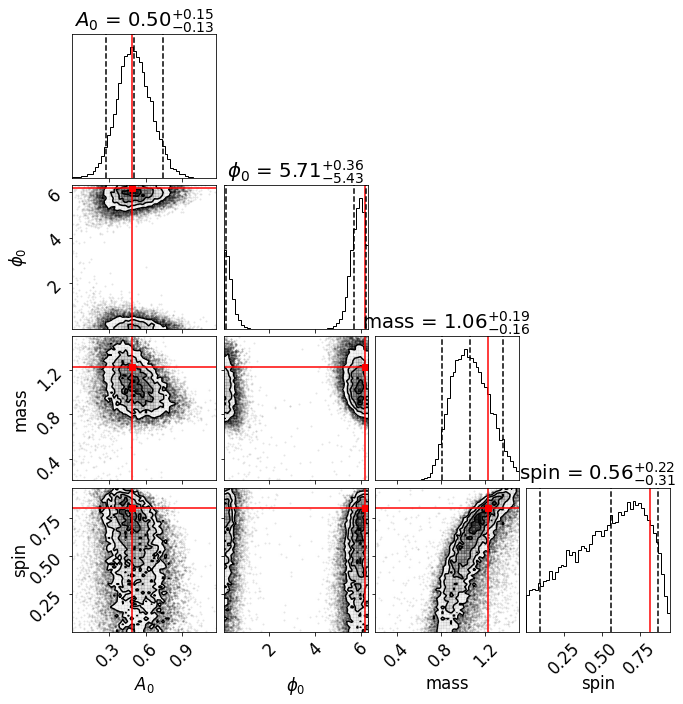

In [67]:
fg=corner.corner(postsamps,quantiles=[0.05,0.5,0.95],show_titles=True,max_n_ticks = 4,bins=50,truths=samps[-1],labels=labels,truth_color='red')
plt.show

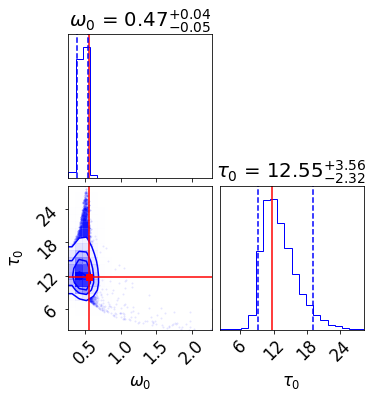

In [68]:
if export:
    fg.savefig(corner_plot, format = 'png', bbox_inches = 'tight')
if model == 'w-tau-fixed-m-af':
    truths=np.concatenate((w,tau))
    samples_2=res.samples
    if fitnoise:
        fmass_spin=(samps.T)[-3:-1].T
    else:
        fmass_spin=(samps.T)[-2:].T
        #fmass_spin=new_samples[-2:]
    fmass_spin_dist=[None]*len(fmass_spin)
    labels_mf = np.concatenate((w_lab,tau_lab))
    weight=np.exp(res.logwt - res.logz[-1])
    for i in range(len(fmass_spin)):
        fmass_spin_dist[i]=np.concatenate(dict_omega[qnm_model](fmass_spin[i,0],fmass_spin[i,1],2,2))
        
    fmass_spin_dist_v2=np.asarray(fmass_spin_dist)
    new_samples = dyfunc.resample_equal(fmass_spin_dist_v2, weight)   
        
    figure = corner.corner(new_samples,truths=truths,quantiles=[0.05,0.95],labels=labels_mf,smooth=True,color='b',truth_color='r',show_titles=True)
    if export:
        figure.savefig(corner_plot_extra, format = 'png', bbox_inches = 'tight')

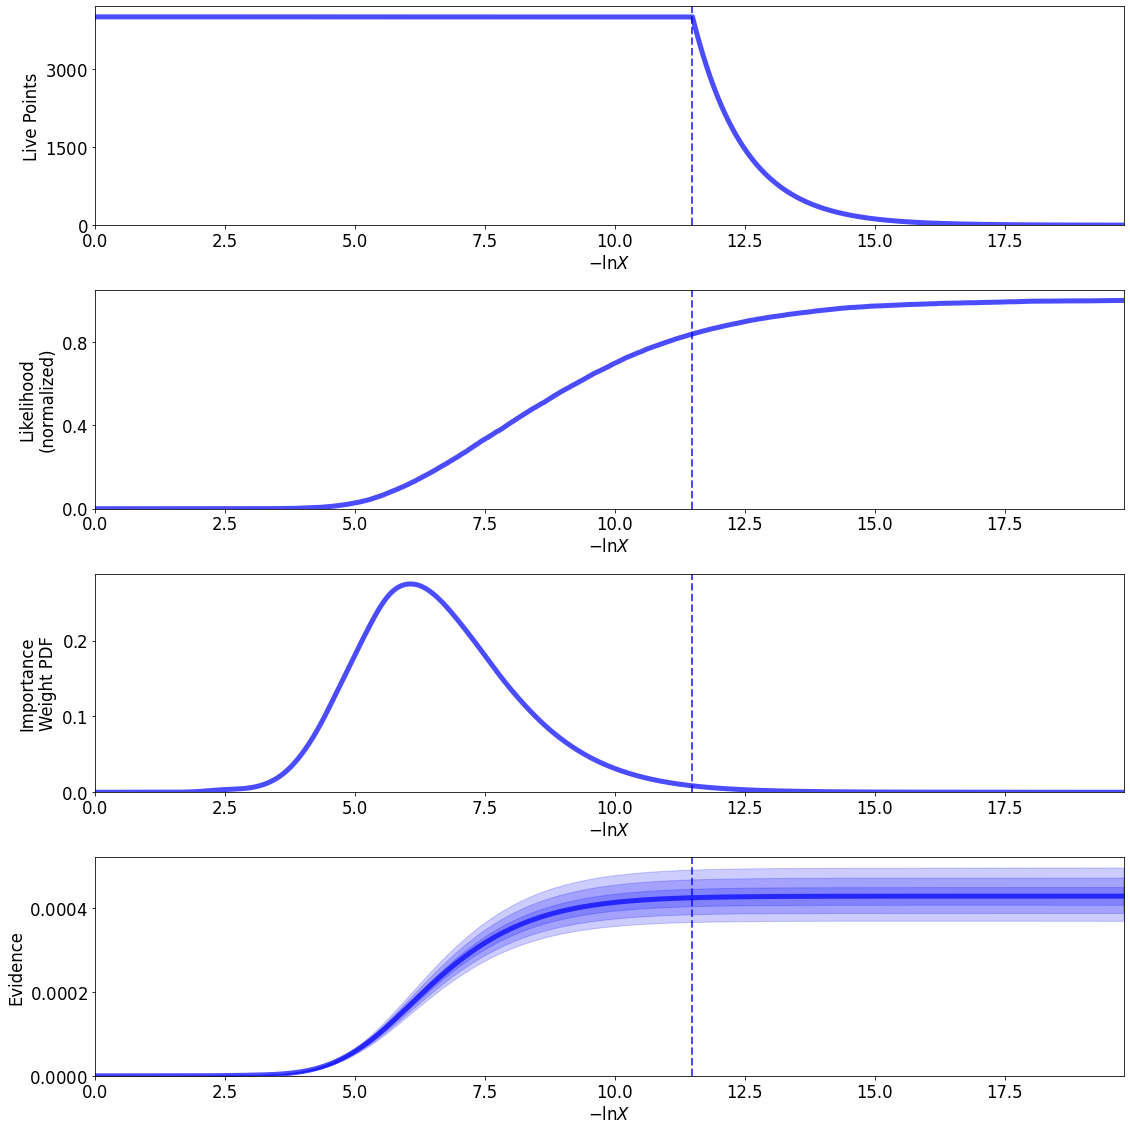

In [69]:
#lnz_truth = ndim * -np.log(2 * 10.)  # analytic evidence solution
fig, axes = dyplot.runplot(res)
fig.tight_layout()
if not eval(overwrite):
    fig.savefig(diagnosis_plot, format = 'png', dpi = 384, bbox_inches = 'tight')

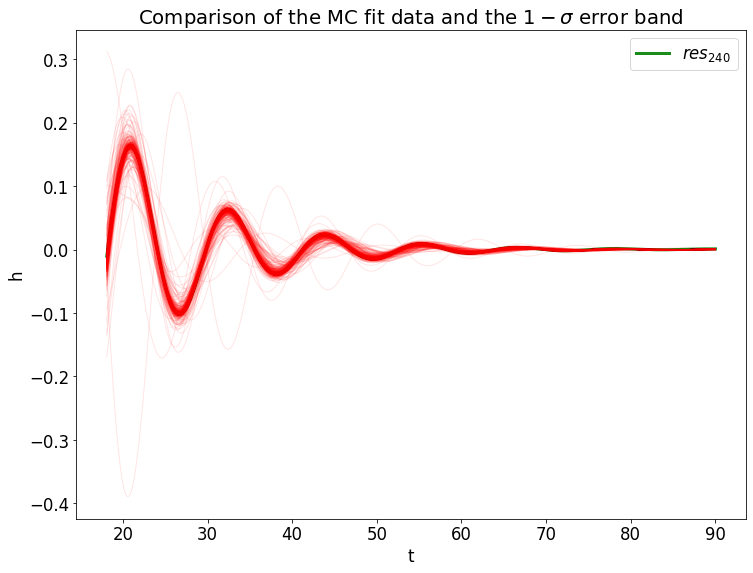

In [154]:
figband = plt.figure(figsize = (12, 9))
plt.plot(timesrd_final_tsh,gwdatanew_re_tsh, "green", alpha=0.9, lw=3, label=r'$res_{240}$')
onesig_bounds = np.array([np.percentile(samps[:, i], [5, 95]) for i in range(len(samps[0]))]).T
samples_1sigma = filter(lambda sample: np.all(onesig_bounds[0] <= sample) and np.all(sample <= onesig_bounds[1]), samps)
samples_1sigma_down = list(samples_1sigma)[::downfactor]
for sample in samples_1sigma_down:
    plt.plot(timesrd_final_tsh, dict[model](sample).real, "r-", alpha=0.1, lw=1)
plt.title(r'Comparison of the MC fit data and the $1-\sigma$ error band')
plt.legend()
plt.xlabel('t')
plt.ylabel('h')
plt.show()

In [90]:
if export:
    figband.savefig(fit_plot)

In [91]:
if export:
    with open(samples_file,'w') as file:
        writer = csv.writer(file)
        writer.writerow(labels)
        writer.writerows(samps[::downfactor])

In [477]:
# To convert back from mass and spin to tones

#if model == 'w-tau-fixed-m-af':

#   fmass_spin=(samps.T)[:2*(nmax+1)].T
#   fmass_spin_dist=[None]*len(fmass_spin)
#   weight=np.exp(res.logwt - res.logz[-1])
#    mass_spin_dist=[None]*len(fmass_spin)
#    for i in range(len(fmass_spin)):
#        fmass_spin_dist[i]=np.concatenate(dict_omega[qnm_model](fmass_spin[i,0],fmass_spin[i,1],2,2))
#        mass_dist = mass_from_wtau_loop(fmass_spin[i,:dim],fmass_spin[i,dim:],2,2) 
#        spin_dist = spin_from_wtau_loop(fmass_spin[i,:dim],fmass_spin[i,dim:],2,2) 
#        mass_spin_dist[i]=np.concatenate((mass_dist,spin_dist))

#    fmass_spin_dist_v2=np.asarray(fmass_spin_dist)
#    new_samples = dyfunc.resample_equal(fmass_spin_dist_v2, weight) 
#    figure = corner.corner(new_samples,quantiles=[0.05,0.95],truths=[mf,af,mf,af],smooth=True,color='b',truth_color='r',show_titles=True)

#if export:    
#    figure.savefig(corner_plot_extra, format = 'png', bbox_inches = 'tight')